I am revisiting this project to try to do a better job analyzing the data. It has been long enough since I first attempted this dataset that I have forgotten what is included. I will try my best to not look at the old notebook because I don't want to repeat anything that I did wrong.

I want to sure a clustering algorithm to get groups from within the data. I think there will be a group where the blue team is clearly doing better but they still lose. I would call that group the group that "threw" the game.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

RED = '#D10000'
BLUE = '#0082FF'

In [2]:
# load the data
data = pd.read_csv('high_diamond_ranked_10min.csv')
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
# let's see what columns we have
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

Some of the columns are the same. For example, blueFirstBlood and redFirstBlood are opposites. So we can only keep one of them.
In this dataset, the target is blueWins which is 1 if the blue team won and 0 if they lost. Since it is based on the blue team, I will try to keep only the blue team information and get rid of the repeated columns that belong to the red team.

First I will make sure the columns are identical.

In [4]:
# verify that the columns are the same
all(data['blueFirstBlood'] == data['redFirstBlood'].apply(lambda x: 0 if x == 1 else 1))

True

Ok, so we can see that these columns contain the same information but they are opposites. It is only worth keeping the blue team one. Let's see which other columns are the same

In [5]:
# gold difference
all(data['blueGoldDiff'] == data['redGoldDiff'].apply(lambda x: -1*x))

True

In [6]:
# experience difference
all(data['blueExperienceDiff'] == data['redExperienceDiff'].apply(lambda x: -1*x))

True

In [7]:
# blue deaths = red kills?
all(data['blueDeaths'] == data['redKills'])

True

In [8]:
# blue kills = red deaths?
all(data['blueKills'] == data['redDeaths'])

True

In [9]:
# let's drop the extra columns, keeping the blue team ones
data.drop(['redFirstBlood','redGoldDiff','redExperienceDiff'], axis = 1, inplace = True)

In [10]:
# drop the red kills and deaths
data.drop(['redKills','redDeaths'], axis = 1, inplace = True)

In [11]:
# gameid doesn't contribute to the characteristics of the games, so we drop that too
data.drop(['gameId'], axis = 1, inplace = True)

In [12]:
# let's gather the blue team columns and the red team columns to make it easier to plot
blue_team = [column for column in data.columns if 'blue' in column]
red_team = [column for column in data.columns if 'red' in column]

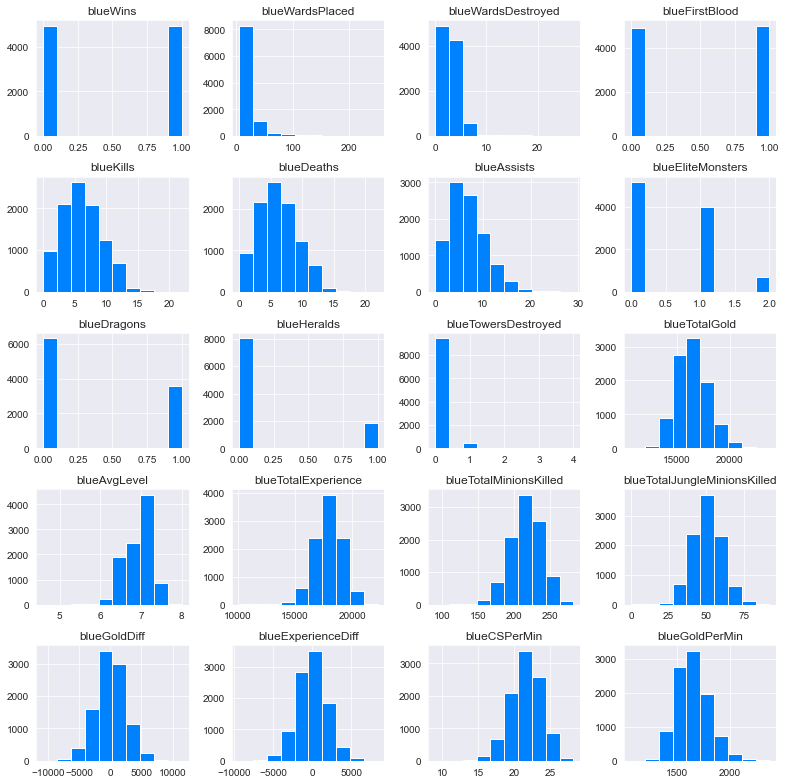

In [13]:
# let's visualize our data

# blue first
data[blue_team].hist(color = BLUE, figsize = (11,11))
plt.tight_layout()
plt.show()

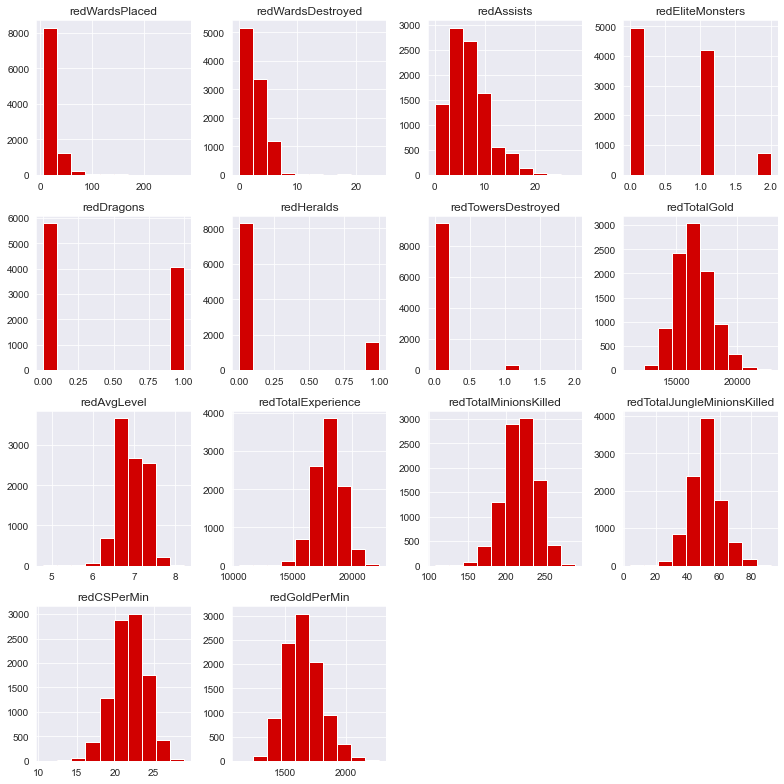

In [14]:
# now red
data[red_team].hist(color = RED, figsize = (11,11))
plt.tight_layout()
plt.show()

# Split the Data

First we will split the data into a training and testing set. I will use a stratified split to ensure there are an equal amount of wins and loses in both sets.

In [15]:
def visualize_distribution(data, title):
    cats = list(data['blueWins'].value_counts().to_dict().keys())
    values = list(data['blueWins'].value_counts().to_dict().values())

    plt.figure(figsize = (5,5))
    g = sns.barplot(x = cats, y = values)
    g.patches[0].set_color(RED)
    g.patches[1].set_color(BLUE)
    g.set_title(title)
    plt.show()

0    4949
1    4930
Name: blueWins, dtype: int64


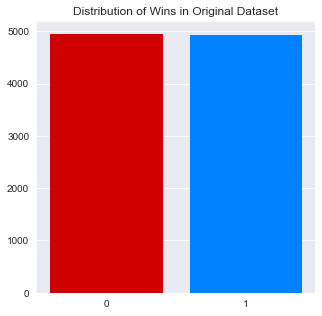

In [16]:
# let's see the distribution of wins and loses
print(data['blueWins'].value_counts())

# visualize this distribution
visualize_distribution(data, 'Distribution of Wins in Original Dataset')

In [17]:
# looks like blue wins 50% of the time and loses 50% of the time. 
# We want to make sure that splitting the data doesn't change this distribution.

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, stratify = data['blueWins'], test_size = 0.2, random_state = 42)

Distribution for training set
0    3959
1    3944
Name: blueWins, dtype: int64


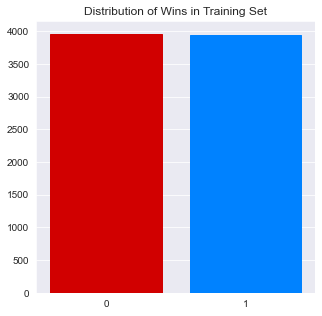

In [18]:
# let's see the distribution of wins and loses for train and test

print('Distribution for training set')
print(train['blueWins'].value_counts())

visualize_distribution(train, 'Distribution of Wins in Training Set')


Distribution for test set
0    0.501012
1    0.498988
Name: blueWins, dtype: float64


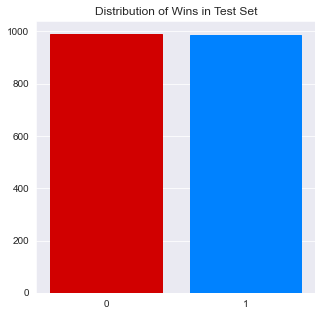

In [19]:
print('\nDistribution for test set')
print(test['blueWins'].value_counts()/test.shape[0])

visualize_distribution(test, 'Distribution of Wins in Test Set')

# Remove Outliers

Outliers could really mess with the data. Let's remove them from the training and test set.

In [20]:
# collect the columns that are "normally distributed".
normal_columns = ['blueWardsPlaced','blueWardsDestroyed','blueKills','blueDeaths',
                  'blueAssists','blueTotalGold','blueAvgLevel','blueTotalExperience',
                  'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
                  'blueGoldDiff','blueExperienceDiff','blueCSPerMin','blueGoldPerMin',
                  'redWardsPlaced','redAssists','redTotalGold','redAvgLevel','redTotalExperience',
                  'redTotalMinionsKilled','redTotalJungleMinionsKilled',
                  'redCSPerMin','redGoldPerMin']

In [21]:
# we need to group the columns with similar range so that the boxplots look interpretable
blue_normal = [column for column in normal_columns if 'blue' in column]
train[blue_normal].describe().T

,count,mean,std,min,25%,50%,75%,max
blueWardsPlaced,7903.0,22.390105,18.172416,5.0,14.0,16.0,20.0,250.0
blueWardsDestroyed,7903.0,2.849424,2.181258,0.0,1.0,3.0,4.0,25.0
blueKills,7903.0,6.177907,3.006991,0.0,4.0,6.0,8.0,22.0
blueDeaths,7903.0,6.139947,2.913440,0.0,4.0,6.0,8.0,19.0
blueAssists,7903.0,6.636847,4.063152,0.0,4.0,6.0,9.0,29.0
blueTotalGold,7903.0,16500.307099,1530.688273,12292.0,15404.0,16396.0,17441.0,23701.0
blueAvgLevel,7903.0,6.916462,0.301386,5.2,6.8,7.0,7.2,8.0
blueTotalExperience,7903.0,17927.073896,1191.996588,11286.0,17162.0,17938.0,18718.0,22224.0
blueTotalMinionsKilled,7903.0,216.689105,21.776130,90.0,202.0,218.0,232.0,283.0
blueTotalJungleMinionsKilled,7903.0,50.461723,9.909079,0.0,44.0,50.0,56.0,88.0


In [22]:
small_blue = ['blueWardsPlaced','blueWardsDestroyed','blueKills',
              'blueDeaths','blueAssists','blueAvgLevel','blueTotalMinionsKilled',
              'blueTotalJungleMinionsKilled','blueCSPerMin']
large_blue = [column for column in blue_normal if column not in small_blue]

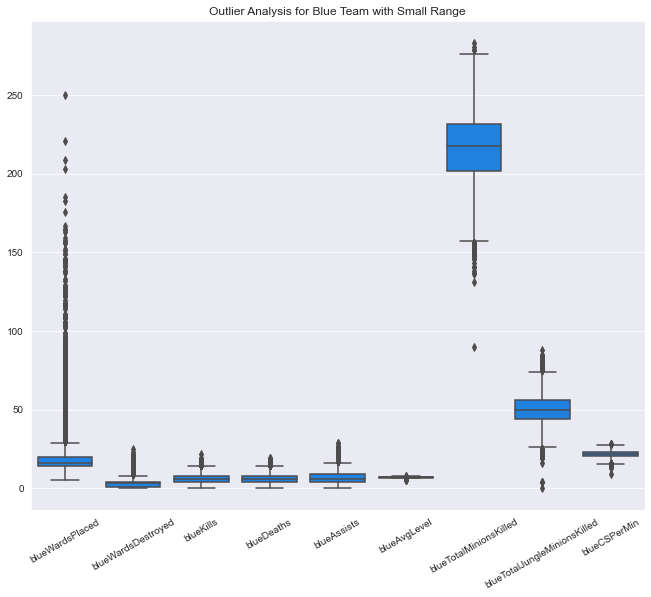

In [23]:
# now we visualize
plt.figure(figsize = (11,9))
g = sns.boxplot(data = train[small_blue], color = BLUE)
g.set_title('Outlier Analysis for Blue Team with Small Range')
plt.xticks(rotation = 30)
plt.show()

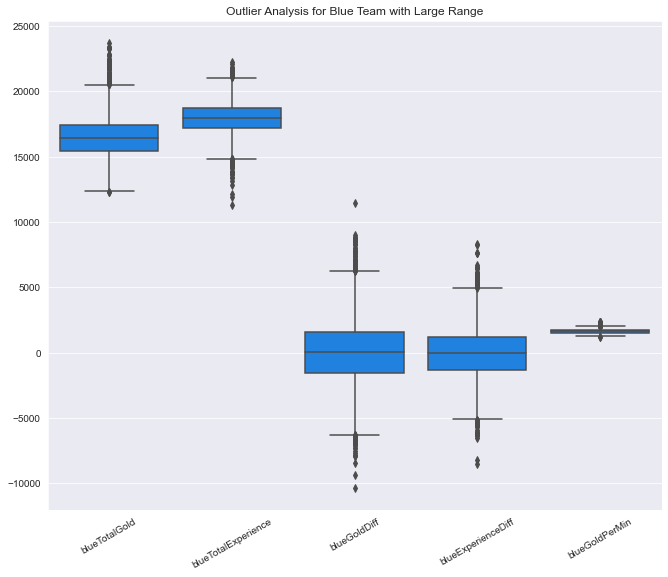

In [24]:
plt.figure(figsize = (11,9))
g = sns.boxplot(data = train[large_blue], color = BLUE)
g.set_title('Outlier Analysis for Blue Team with Large Range')
plt.xticks(rotation = 30)
plt.show()

We can see that there are outliers in all of these columns. We will eliminate the outliers and check to see if the boxplots look fine.

In [25]:
def remove_outliers(data, columns):
    """
    Remove the outlier if it is 3 standard deviations away from the mean
    """
    for column in columns:
        column_mean = data[column].mean()
        column_std = data[column].std()
        threshold = column_std*3 # three standard deviations
        lower, upper = column_mean - threshold, column_mean + threshold
        data = data[(data[column] >= lower) & (data[column] <= upper)]
    return data

In [26]:
# remove the outliers for the blue team
train_no_outliers = remove_outliers(train, [column for column in normal_columns if 'blue' in column])

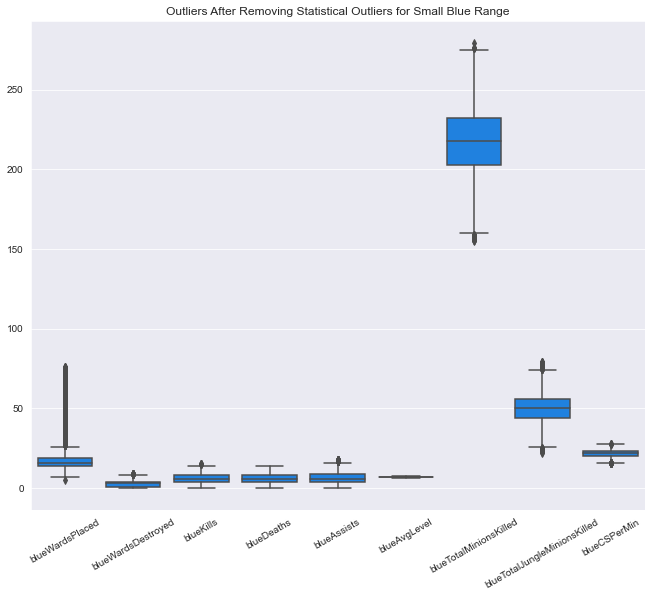

In [27]:
# let's see if it worked
# now we visualize
plt.figure(figsize = (11,9))
g = sns.boxplot(data = train_no_outliers[small_blue], color = BLUE)
g.set_title('Outliers After Removing Statistical Outliers for Small Blue Range')
plt.xticks(rotation = 30)
plt.show()

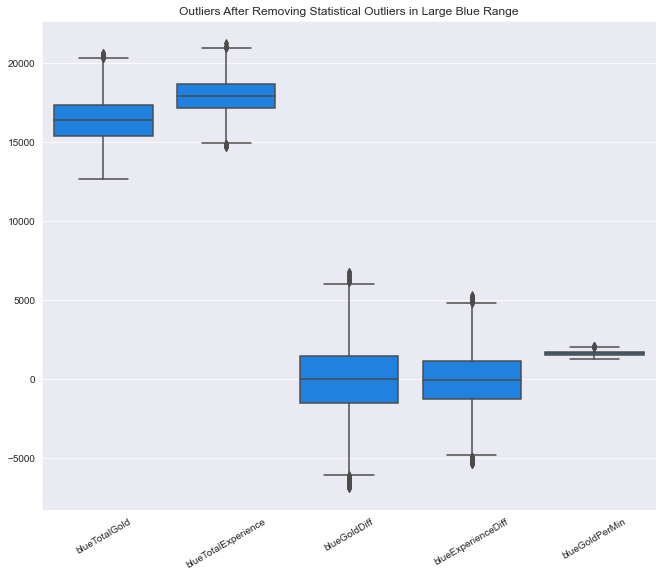

In [28]:
plt.figure(figsize = (11,9))
g = sns.boxplot(data = train_no_outliers[large_blue], color = BLUE)
g.set_title('Outliers After Removing Statistical Outliers in Large Blue Range')
plt.xticks(rotation = 30)
plt.show()

Now we do the same for the red team

In [29]:
red_normal = [column for column in normal_columns if 'red' in column]
data[red_normal].describe().T

,count,mean,std,min,25%,50%,75%,max
redWardsPlaced,9879.0,22.367952,18.457427,6.0,14.00,16.0,20.00,276.0
redAssists,9879.0,6.662112,4.060612,0.0,4.00,6.0,9.00,28.0
redTotalGold,9879.0,16489.041401,1490.888406,11212.0,15427.50,16378.0,17418.50,22732.0
redAvgLevel,9879.0,6.925316,0.305311,4.8,6.80,7.0,7.20,8.2
redTotalExperience,9879.0,17961.730438,1198.583912,10465.0,17209.50,17974.0,18764.50,22269.0
redTotalMinionsKilled,9879.0,217.349226,21.911668,107.0,203.00,218.0,233.00,289.0
redTotalJungleMinionsKilled,9879.0,51.313088,10.027885,4.0,44.00,51.0,57.00,92.0
redCSPerMin,9879.0,21.734923,2.191167,10.7,20.30,21.8,23.30,28.9
redGoldPerMin,9879.0,1648.904140,149.088841,1121.2,1542.75,1637.8,1741.85,2273.2


In [30]:
small_red = ['redWardsPlaced','redAssists','redAvgLevel',
             'redTotalMinionsKilled','redTotalJungleMinionsKilled', 
             'redCSPerMin']
large_red = [column for column in red_normal if column not in small_red]

In [31]:
def plot_boxplot(data, subset, color, title):
    plt.figure(figsize = (11,9))
    g = sns.boxplot(data = data[subset], color = color)
    g.set_title(title)
    plt.xticks(rotation = 30)
    plt.show()

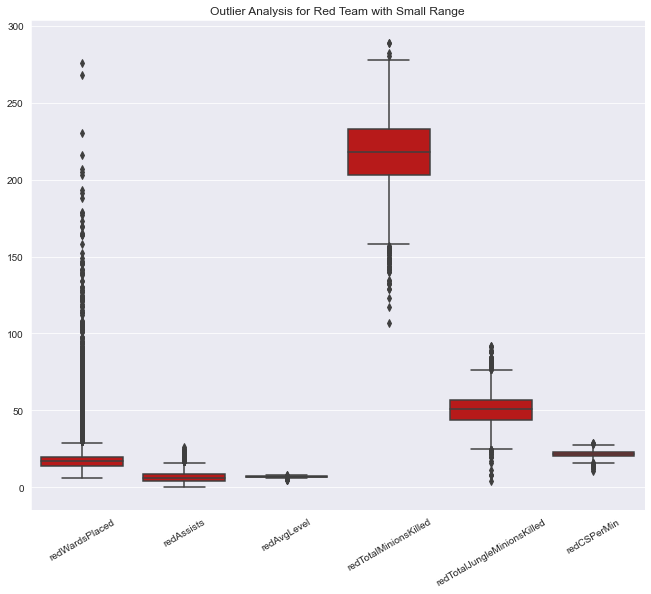

In [32]:
# visualize small red
plot_boxplot(train, small_red, RED, 'Outlier Analysis for Red Team with Small Range')

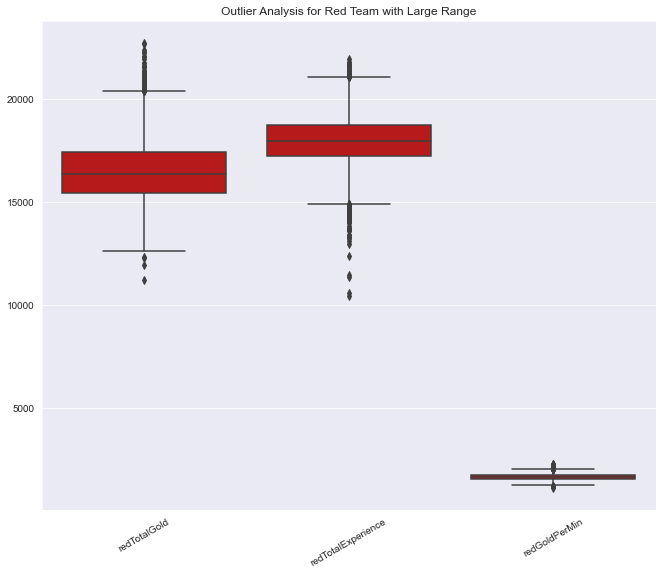

In [33]:
# large red
plot_boxplot(train, large_red, RED, 'Outlier Analysis for Red Team with Large Range')

In [34]:
# now we remove outliers for red team in the training set
train_no_outliers = remove_outliers(train, [column for column in normal_columns if 'red' in column])

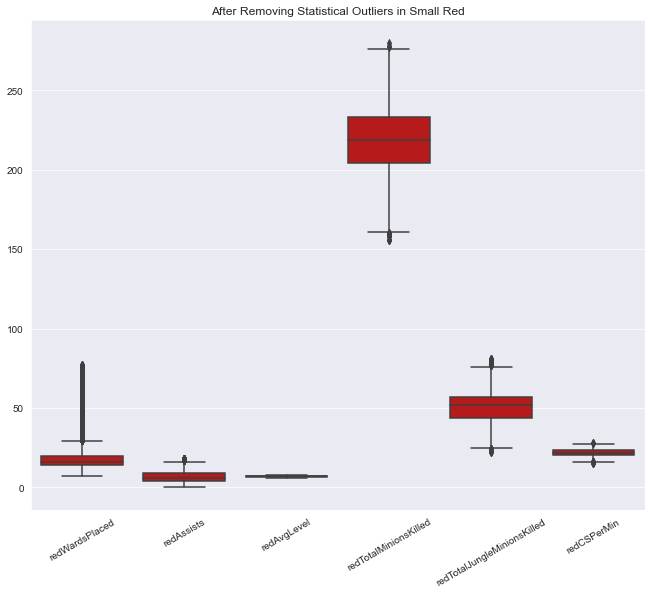

In [35]:
# plot again to see if there are less outliers
plot_boxplot(train_no_outliers, small_red, RED, 'After Removing Statistical Outliers in Small Red')

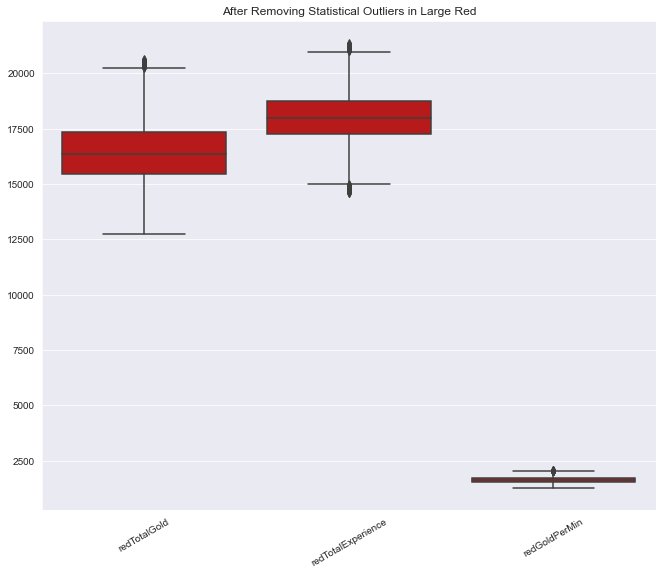

In [36]:
plot_boxplot(train_no_outliers, large_red, RED, 'After Removing Statistical Outliers in Large Red')

# Rescaling the Features for Clustering

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_tr = scaler.fit_transform(train_no_outliers.drop('blueWins', axis = 1))
train_tr = pd.DataFrame(train_tr, columns = train_no_outliers.drop('blueWins', axis = 1).columns)

# add the bluewins column back in
train_tr['blueWins'] = train_no_outliers['blueWins']

In [38]:
train_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
blueWardsPlaced,7465.0,8.566490e-17,1.000067,-0.956328,-0.408275,-0.298665,-0.134249,12.470961
blueWardsDestroyed,7465.0,-2.903088e-17,1.000067,-1.313617,-0.393284,0.066883,0.527049,10.190546
blueFirstBlood,7465.0,2.855497e-18,1.000067,-1.011181,-1.011181,0.988943,0.988943,0.988943
blueKills,7465.0,-1.016081e-16,1.000067,-2.071999,-0.718971,-0.042458,0.634056,5.369653
blueDeaths,7465.0,-1.446785e-16,1.000067,-2.165557,-0.734695,-0.019263,0.696168,4.273323
blueAssists,7465.0,-3.807329e-18,1.000067,-1.647034,-0.645192,-0.144271,0.607111,5.616323
blueEliteMonsters,7465.0,3.616962e-17,1.000067,-0.881742,-0.881742,-0.881742,0.717044,2.315830
blueDragons,7465.0,1.256419e-16,1.000067,-0.757999,-0.757999,-0.757999,1.319263,1.319263
blueHeralds,7465.0,4.473611e-17,1.000067,-0.478972,-0.478972,-0.478972,-0.478972,2.087807
blueTowersDestroyed,7465.0,-9.518322e-18,1.000067,-0.206114,-0.206114,-0.206114,-0.206114,13.370105


In [39]:
# looks like we dropped a few of the 'blueWins' column. Let's remove the rows that contain NA
train_tr.dropna(inplace = True, axis = 0)
train_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
blueWardsPlaced,5649.0,0.009871,1.020546,-0.956328,-0.408275,-0.298665,-0.134249,12.470961
blueWardsDestroyed,5649.0,0.009291,1.017615,-1.313617,-0.393284,0.066883,0.527049,10.190546
blueFirstBlood,5649.0,0.007469,0.999978,-1.011181,-1.011181,0.988943,0.988943,0.988943
blueKills,5649.0,0.006344,1.003927,-2.071999,-0.718971,-0.042458,0.634056,5.369653
blueDeaths,5649.0,0.001063,1.009674,-2.165557,-0.734695,-0.019263,0.696168,4.273323
blueAssists,5649.0,0.009712,1.004454,-1.647034,-0.645192,-0.144271,0.607111,5.616323
blueEliteMonsters,5649.0,-0.001546,0.998691,-0.881742,-0.881742,-0.881742,0.717044,2.315830
blueDragons,5649.0,-0.002330,0.999432,-0.757999,-0.757999,-0.757999,1.319263,1.319263
blueHeralds,5649.0,0.000397,1.000408,-0.478972,-0.478972,-0.478972,-0.478972,2.087807
blueTowersDestroyed,5649.0,0.002172,1.018400,-0.206114,-0.206114,-0.206114,-0.206114,13.370105


# Cluster with K-Means

We will find the optimal number of clusters using the elbow-inertia technique. We can also look at the silhouette score to see which number of clusters works best.

I believe there will be 4 optimal clusters. Two of the clusters should be where blue team is in the lead *and* they win and the other will be where blue team is in the lead *but* they lose. Vice versa for red team.

In [40]:
from sklearn.cluster import KMeans
# code from HOML
k_means_list = [KMeans(n_clusters = k, random_state = 42).fit(train_tr.values) for k in range(1,10)]
inertias = [model.inertia_ for model in k_means_list]

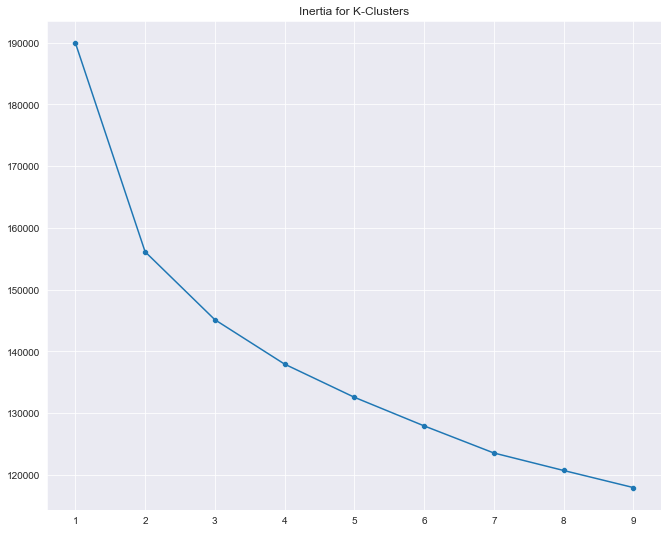

In [41]:
# now we plot
plt.figure(figsize = (11,9))

# lines
g = sns.lineplot(x = [val for val in range(1,10)],
                 y = inertias)
# points
g = sns.scatterplot(x = [val for val in range(1,10)],
                    y = inertias)

g.set_title('Inertia for K-Clusters')
plt.show()

From the elbow plot above, we can see that the elbow occurs at 2 clusters. This is probably just blue wins or loses. I was hoping to see 4 clusters. Perhaps the silhouette score will show more.

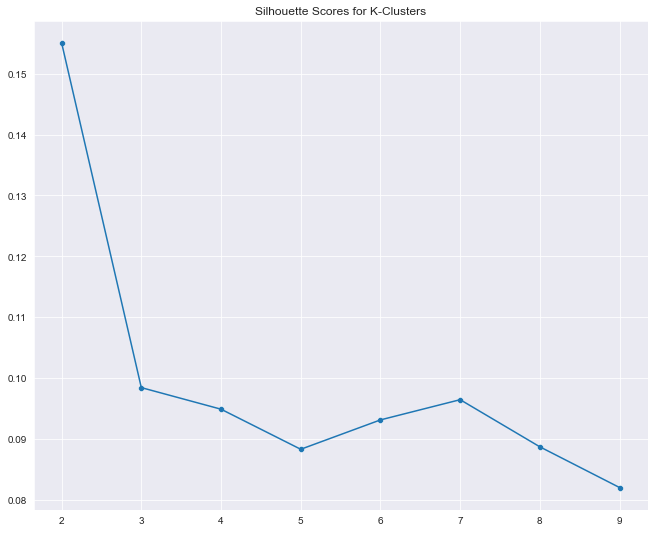

In [42]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(train_tr.values, model.labels_)
                     for model in k_means_list[1:]]

# now we plot
plt.figure(figsize = (11,9))

# lines
g = sns.lineplot(x = [val for val in range(2,10)],
                 y = silhouette_scores)
# points
g = sns.scatterplot(x = [val for val in range(2,10)],
                    y = silhouette_scores)

g.set_title('Silhouette Scores for K-Clusters')
plt.show()

Ok, so the silhouette score for the k-means algorithm is closer to 0 than 1. This implies that the clusters aren't that good. We also see the inertia scores are relatively high. Perhaps using an unsupervised learning algorithm for a dataset where we already know the outcomes is not the best idea.

We will try again with k-nearest neighbors.

# K-Nearest Neighbors

In [43]:
from sklearn.neighbors import KNeighborsClassifier

# first, let's make a validation set from the training set

train, valid = train_test_split(train_tr, stratify = train_tr['blueWins'],
                                test_size = 0.2)



X_train = train.drop('blueWins', axis = 1).values
X_valid = valid.drop('blueWins', axis = 1).values
y_train = train['blueWins'].values
y_valid = valid['blueWins'].values

In [44]:
from sklearn.metrics import accuracy_score

# we will run the knn classifier for k from 2-10)
knn_list = [KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
            for k in range(2, 10)]
accuracy_list = [accuracy_score(y_train, model.predict(X_train))
                 for model in knn_list]

In [45]:
for k, accuracy in zip(range(2,10), accuracy_list):
    print('For k = {}, Accuracy = {:.2f}%'.format(k, accuracy*100))

For k = 2, Accuracy = 75.37%
For k = 3, Accuracy = 76.26%
For k = 4, Accuracy = 70.50%
For k = 5, Accuracy = 69.35%
For k = 6, Accuracy = 66.61%
For k = 7, Accuracy = 66.47%
For k = 8, Accuracy = 65.57%
For k = 9, Accuracy = 64.93%


# Interesting Visualizations

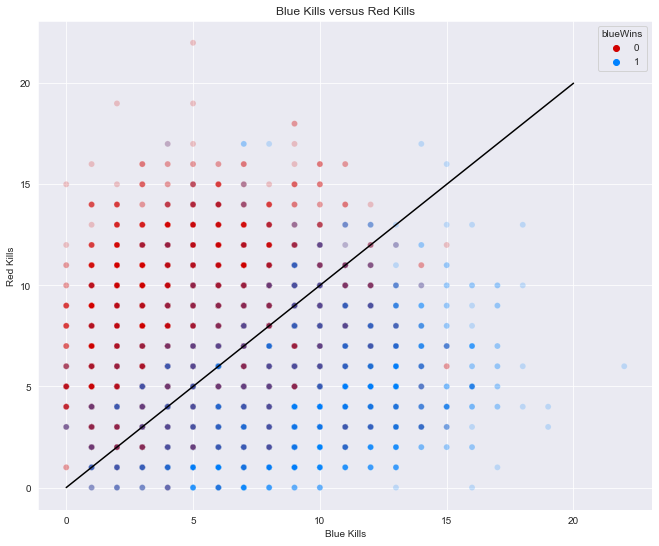

In [74]:
# interesting graphs
sns.set_palette(sns.color_palette([RED, BLUE]))
plt.figure(figsize = (11,9))
plt.plot([0,20], [0,20], '-k')
g = sns.scatterplot(data = data,
                    x = 'blueKills',
                    y = 'blueDeaths',
                    hue = 'blueWins',
                    alpha = 0.2)
g.set(xlabel = 'Blue Kills', ylabel = 'Red Kills', title = 'Blue Kills versus Red Kills')
plt.show()

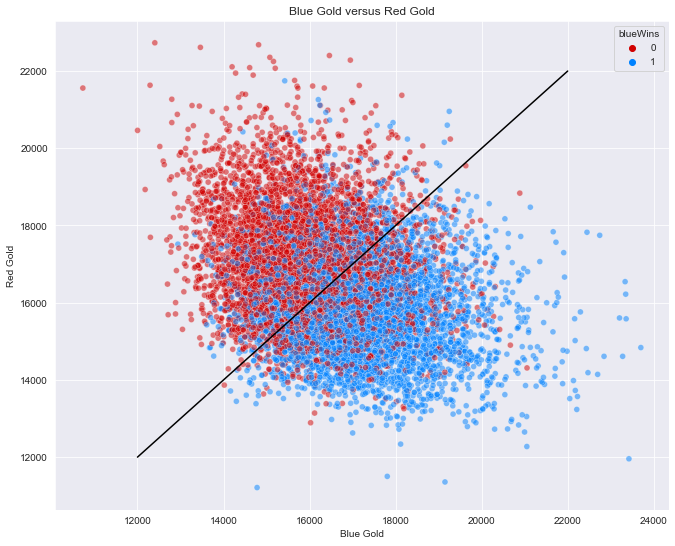

In [47]:
# gold
plt.figure(figsize = (11,9))
plt.plot([12000,22000], [12000,22000], 'k-')
g = sns.scatterplot(data = data,
                    x = 'blueTotalGold',
                    y = 'redTotalGold',
                    hue = 'blueWins',
                    alpha = 0.5)
g.set(xlabel = 'Blue Gold', ylabel = 'Red Gold', title = 'Blue Gold versus Red Gold')
plt.show()

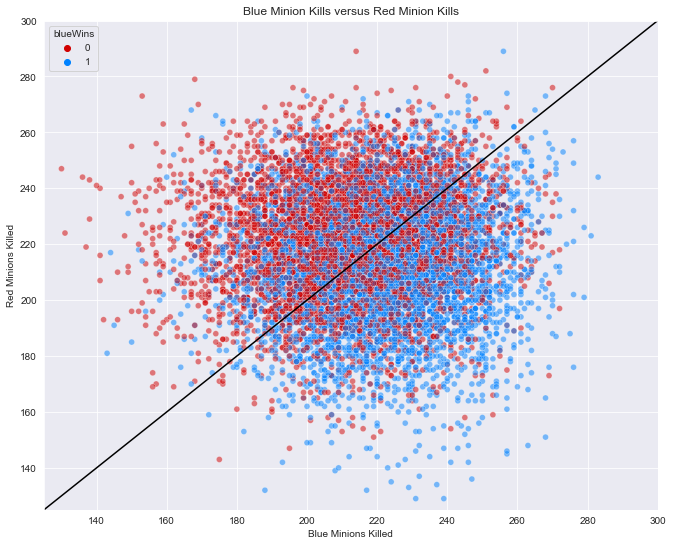

In [48]:
# minion kills
plt.figure(figsize = (11,9))
plt.plot([125,300],[125,300], 'k-')
g = sns.scatterplot(data = data,
                    x = 'blueTotalMinionsKilled',
                    y = 'redTotalMinionsKilled',
                    hue = 'blueWins',
                    alpha = 0.5)
g.set(xlim = (125,300), ylim = (125,300))
g.set(xlabel = 'Blue Minions Killed', ylabel = 'Red Minions Killed', 
      title = 'Blue Minion Kills versus Red Minion Kills')
plt.show()

# Make Team Advantage Column

In [49]:
# I think first there should be a vision score column
data['blueVisionScore'] = data['blueWardsPlaced'] + data['redWardsDestroyed']
data['redVisionScore'] = data['redWardsPlaced'] + data['blueWardsDestroyed']
data.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds',
       'redTowersDestroyed', 'redTotalGold', 'redAvgLevel',
       'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin',
       'blueVisionScore', 'redVisionScore'],
      dtype='object')

We should compare (blue kills and red kills), 
(blue assists and red assists), (blue elite monsters and red elite monsters), 
(blue dragons and red dragons), (blue heralds and red heralds),
(blue towers destroyed and red towers destroyed),
(blue avg level and red avg level),
(blue total minions killed and red total minions killed), (blue jungle minions killed and red jungle minions killed),
(gold difference), (experience difference), (blue cs per min and red cs per min), (blue gold per min and red gold per min),
and (vision score)

In [51]:
# first we define a column that contains points for how advantaged the team is
data['blueAdvantagePoints'] = [0]*data.shape[0]
for ind in range(data.shape[0]):
    data.loc[ind ,'blueAdvantagePoints'] = int(data['blueKills'].iloc[ind] > data['blueDeaths'].iloc[ind]) + int(data['blueAssists'].iloc[ind] > data['redAssists'].iloc[ind]) + int(data['blueEliteMonsters'].iloc[ind] > data['redEliteMonsters'].iloc[ind]) + int(data['blueDragons'].iloc[ind] > data['redDragons'].iloc[ind]) + int(data['blueHeralds'].iloc[ind] > data['redHeralds'].iloc[ind]) + int(data['redTowersDestroyed'].iloc[ind] > data['blueTowersDestroyed'].iloc[ind]) + int(data['blueAvgLevel'].iloc[ind] > data['redAvgLevel'].iloc[ind]) + int(data['blueTotalMinionsKilled'].iloc[ind] > data['redTotalMinionsKilled'].iloc[ind]) + int(data['blueTotalJungleMinionsKilled'].iloc[ind] > data['redTotalJungleMinionsKilled'].iloc[ind]) + int(data['blueGoldDiff'].iloc[ind] > 0) + int(data['blueExperienceDiff'].iloc[ind] > 0) + int(data['blueCSPerMin'].iloc[ind] > data['redCSPerMin'].iloc[ind]) + int(data['blueGoldPerMin'].iloc[ind] > data['redGoldPerMin'].iloc[ind]) + int(data['blueVisionScore'].iloc[ind] > data['redVisionScore'].iloc[ind])

In [52]:
# now the red team
data['redAdvantagePoints'] = [0]*data.shape[0]
for ind in range(data.shape[0]):
    data.loc[ind ,'redAdvantagePoints'] = int(data['blueKills'].iloc[ind] < data['blueDeaths'].iloc[ind]) + int(data['blueAssists'].iloc[ind] < data['redAssists'].iloc[ind]) + int(data['blueEliteMonsters'].iloc[ind] < data['redEliteMonsters'].iloc[ind]) + int(data['blueDragons'].iloc[ind] < data['redDragons'].iloc[ind]) + int(data['blueHeralds'].iloc[ind] < data['redHeralds'].iloc[ind]) + int(data['redTowersDestroyed'].iloc[ind] < data['blueTowersDestroyed'].iloc[ind]) + int(data['blueAvgLevel'].iloc[ind] < data['redAvgLevel'].iloc[ind]) + int(data['blueTotalMinionsKilled'].iloc[ind] < data['redTotalMinionsKilled'].iloc[ind]) + int(data['blueTotalJungleMinionsKilled'].iloc[ind] < data['redTotalJungleMinionsKilled'].iloc[ind]) + int(data['blueGoldDiff'].iloc[ind] < 0) + int(data['blueExperienceDiff'].iloc[ind] < 0) + int(data['blueCSPerMin'].iloc[ind] < data['redCSPerMin'].iloc[ind]) + int(data['blueGoldPerMin'].iloc[ind] < data['redGoldPerMin'].iloc[ind]) + int(data['blueVisionScore'].iloc[ind] < data['redVisionScore'].iloc[ind])

In [53]:
data.loc[:5, ('blueAdvantagePoints', 'redAdvantagePoints')]

,blueAdvantagePoints,redAdvantagePoints
0,5,5
1,2,10
2,4,8
3,4,7
4,2,8
5,9,2


In [54]:
# finally, we make a column defining whether blue team has the advantage or not.
data['blueAdvantage'] = [np.nan]*data.shape[0]
for ind in range(data.shape[0]):
    if data.loc[ind, 'blueAdvantagePoints'] > data.loc[ind, 'redAdvantagePoints']:
        data.loc[ind, 'blueAdvantage'] = 1
    elif data.loc[ind, 'blueAdvantagePoints'] < data.loc[ind, 'redAdvantagePoints']:
        data.loc[ind, 'blueAdvantage'] = 0
    else:
        data.loc[ind, 'blueAdvantage'] = np.nan

In [55]:
data.loc[:5, ('blueAdvantagePoints', 'redAdvantagePoints', 'blueAdvantage')]

,blueAdvantagePoints,redAdvantagePoints,blueAdvantage
0,5,5,NaN
1,2,10,0.0
2,4,8,0.0
3,4,7,0.0
4,2,8,0.0
5,9,2,1.0


In [56]:
# now let's see what percent of games blue team lost when they had the advantage
# I suspect it is around 20-25%
blue_loss_with_advantage = data[(data['blueWins'] == 0) & (data['blueAdvantage'] == 1)].shape[0]/data.shape[0]
red_loss_with_advantage = data[(data['blueWins'] == 1) & (data['blueAdvantage'] == 0)].shape[0]/data.shape[0]

print('Percent of games where blue lost even with the advantage: {:.2f}%\n'.format(blue_loss_with_advantage*100))
print('Percent of games where red lost even with the advantage: {:.2f}%'.format(red_loss_with_advantage*100))

Percent of games where blue lost even with the advantage: 13.12%

Percent of games where red lost even with the advantage: 13.30%


# Visualizing With Advantage

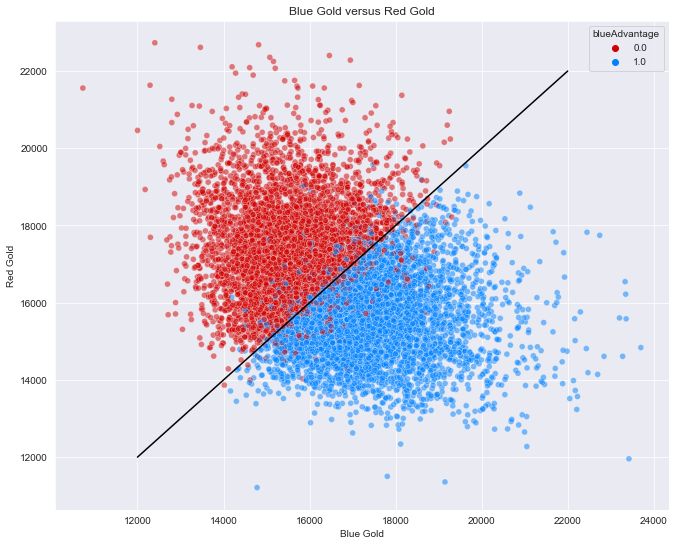

In [57]:
data_copy = data.dropna(axis = 0) # the games where both teams had an equal advantage

# gold
plt.figure(figsize = (11,9))
plt.plot([12000,22000], [12000,22000], 'k-')
g = sns.scatterplot(data = data_copy,
                    x = 'blueTotalGold',
                    y = 'redTotalGold',
                    hue = 'blueAdvantage',
                    alpha = 0.5)
g.set(xlabel = 'Blue Gold', ylabel = 'Red Gold', title = 'Blue Gold versus Red Gold')
plt.show()

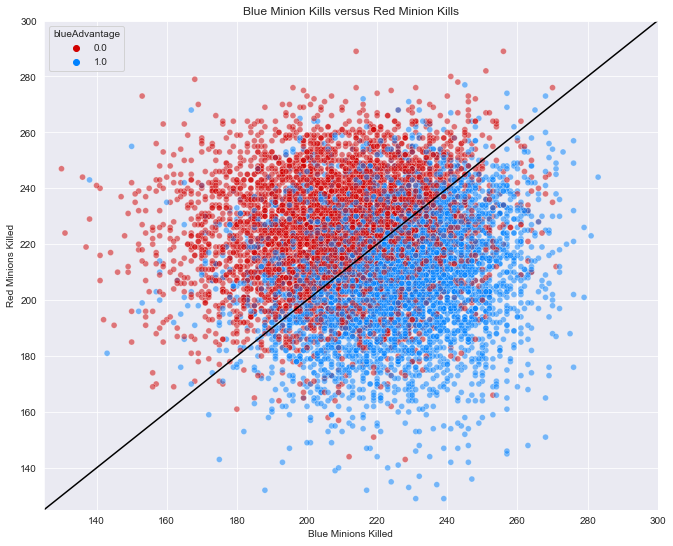

In [58]:
# minion kills
plt.figure(figsize = (11,9))
plt.plot([125,300],[125,300], 'k-')
g = sns.scatterplot(data = data_copy,
                    x = 'blueTotalMinionsKilled',
                    y = 'redTotalMinionsKilled',
                    hue = 'blueAdvantage',
                    alpha = 0.5)
g.set(xlim = (125,300), ylim = (125,300))
g.set(xlabel = 'Blue Minions Killed', ylabel = 'Red Minions Killed', 
      title = 'Blue Minion Kills versus Red Minion Kills')
plt.show()

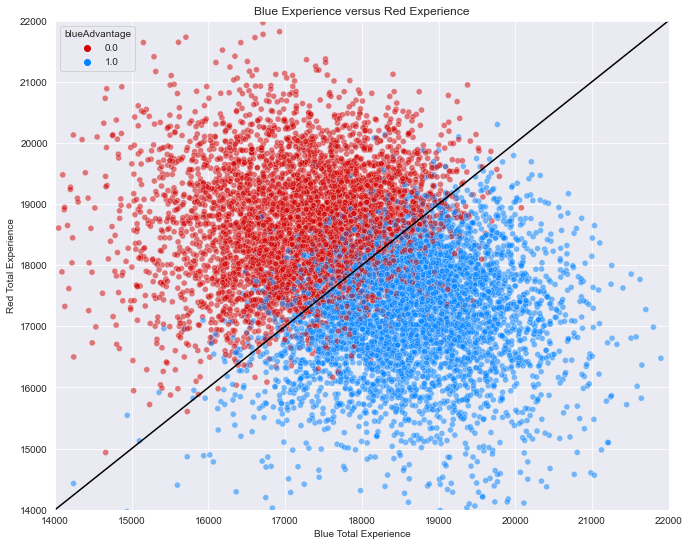

In [64]:
# total experience
plt.figure(figsize = (11,9))
plt.plot([14000,22000],[14000,22000], 'k-')
g = sns.scatterplot(data = data_copy,
                    x = 'blueTotalExperience',
                    y = 'redTotalExperience',
                    hue = 'blueAdvantage',
                    alpha = 0.5)

g.set(xlim = (14000,22000), ylim = (14000,22000))
g.set(xlabel = 'Blue Total Experience', ylabel = 'Red Total Experience', 
      title = 'Blue Experience versus Red Experience')
plt.show()

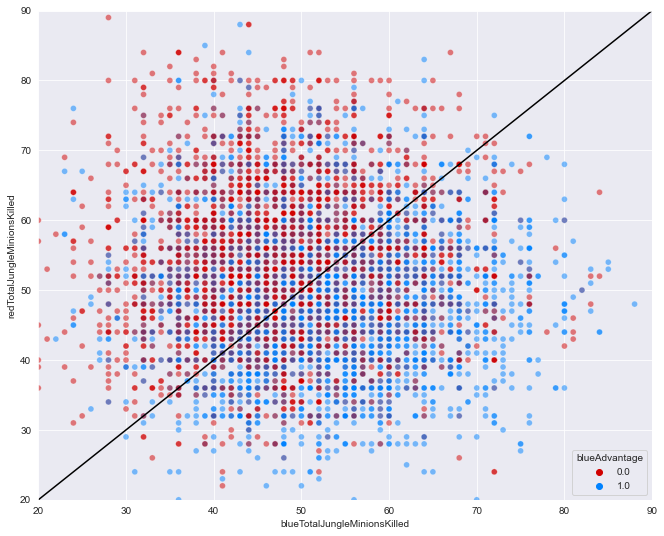

In [70]:
# jungle diff?
plt.figure(figsize = (11,9))
plt.plot([20,90], [20,90], 'k-')
g = sns.scatterplot(data = data_copy, x = 'blueTotalJungleMinionsKilled',
                y = 'redTotalJungleMinionsKilled',
                hue = 'blueAdvantage',
                alpha = 0.5)

g.set(xlim = (20,90), ylim = (20,90))
plt.show()

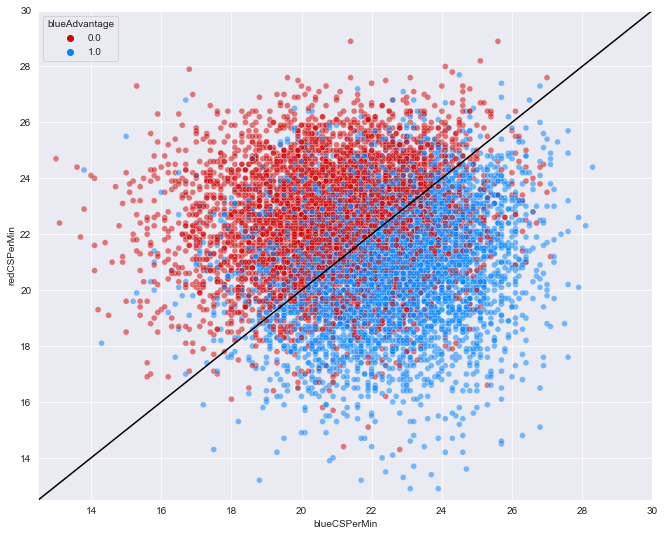

In [72]:
# cs per minute
plt.figure(figsize = (11,9))
plt.plot([12.5,30], [12.5,30], 'k-')
g = sns.scatterplot(data = data_copy,
                    x = 'blueCSPerMin',
                    y = 'redCSPerMin',
                    hue = 'blueAdvantage',
                    alpha = 0.5)
g.set(xlim = (12.5,30), ylim = (12.5,30))
plt.show()

In [ ]:
# towers destroyed
